In [44]:
import os

import pandas as pd
import numpy as np

In [45]:
df = pd.read_csv(os.path.join(os.getcwd(), "data/20240603/LW-2_20240603_180436_243.csv"), skiprows=11)

In [46]:
df["FreeAccMagnitude"] = (df["FreeAcc_X"]**2 + df["FreeAcc_Y"]**2 + df["FreeAcc_Z"]**2)**0.5

<Axes: >

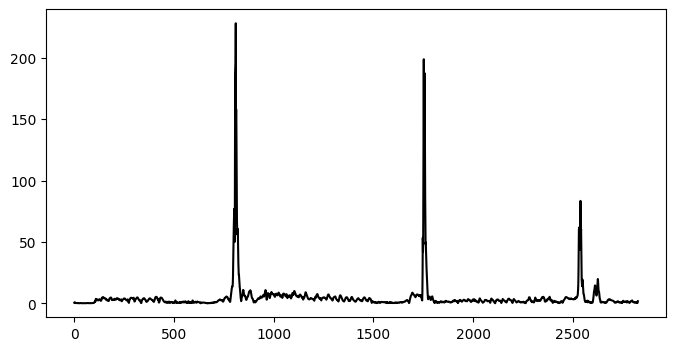

In [47]:
df["FreeAccMagnitude"].plot(figsize=(8, 4), c='black')

In [48]:
# use isolation forest to detect anomalies
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.015)
clf.fit(df[["FreeAccMagnitude"]])

IsolationForest(contamination=0.015)

In [49]:
# predict the anomalies
df["Anomaly"] = clf.predict(df[["FreeAccMagnitude"]])

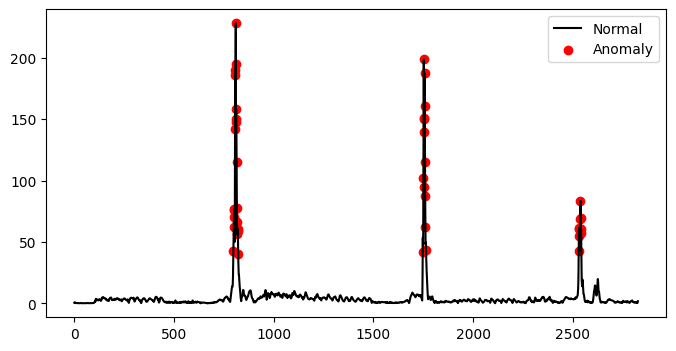

In [50]:
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
anomalies = df.loc[df['Anomaly'] == -1, ['FreeAccMagnitude']]  # Anomaly
ax.plot(df.index, df['FreeAccMagnitude'], color='black', label='Normal')
ax.scatter(anomalies.index, anomalies['FreeAccMagnitude'], color='red', label='Anomaly')
plt.legend()
plt.show()

In [51]:
# get list of timestamps of anomalies
anomalies = np.array(df.loc[df['Anomaly'] == -1].index.tolist()).reshape(-1, 1)

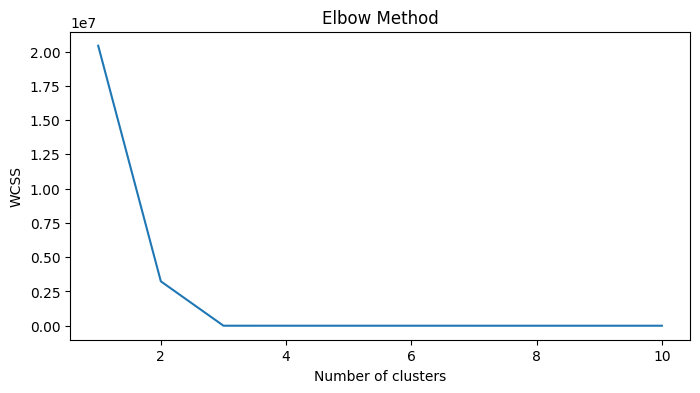

In [52]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(anomalies)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [53]:
# automaize the elbow method with kneed
from kneed import KneeLocator

kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
kl.elbow

3

In [54]:
# k means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=kl.elbow, random_state=0)
kmeans.fit(anomalies)

KMeans(n_clusters=3, random_state=0)

In [55]:
cluster_representatives = kmeans.cluster_centers_.round().astype(int).reshape(-1,)
cluster_representatives

array([1756,  811, 2536])

In [56]:
df["AnomalyGroup"] = 0
df.loc[cluster_representatives, "AnomalyGroup"] = 1

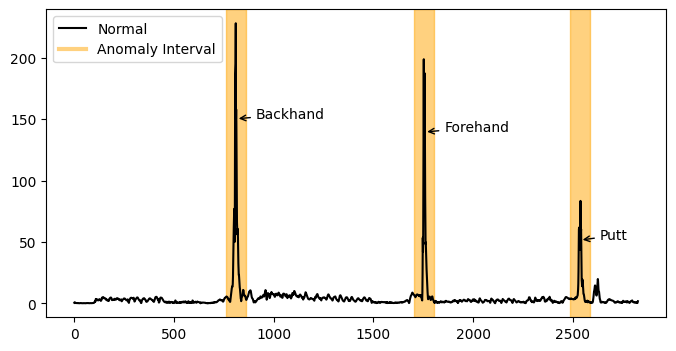

In [57]:
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
anomalies = df.loc[df['AnomalyGroup'] == 1, ['FreeAccMagnitude']]  # Anomaly
ax.plot(df.index, df['FreeAccMagnitude'], color='black', label='Normal')
# ax.scatter(anomalies.index, anomalies['FreeAccMagnitude'], color='red', label='Anomaly', s=100)

# Add color intervals
for index, row in anomalies.iterrows():
    start_index = max(0, index - 50)  # Start index of the color interval
    end_index = min(len(df.index) - 1, index + 50)  # End index of the color interval
    ax.axvspan(df.index[start_index], df.index[end_index], color='orange', alpha=0.5)

# add legend for the color intervals
ax.plot([], [], color='orange', alpha=0.5, label='Anomaly Interval', linewidth=3)

# add pointers to the anomalies indicating that first intervals shows backhand, seocond interval shows forehand and last a putt
ax.annotate('Backhand', xy=(anomalies.index[0], anomalies['FreeAccMagnitude'].values[0]), xytext=(anomalies.index[0] + 100, anomalies['FreeAccMagnitude'].values[0] + 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('Forehand', xy=(anomalies.index[1], anomalies['FreeAccMagnitude'].values[1]), xytext=(anomalies.index[1] + 100, anomalies['FreeAccMagnitude'].values[1] + 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('Putt', xy=(anomalies.index[2], anomalies['FreeAccMagnitude'].values[2]), xytext=(anomalies.index[2] + 100, anomalies['FreeAccMagnitude'].values[2] + 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.legend()
plt.show()